# Physical Risk Propagation Model (EU-27 SAM)

This notebook:
1. Loads the latest EU-27 SAM (long format)
2. Extracts IO-style model inputs (Z, FD, X, A, globsec_of, node_labels)
3. Runs scenario simulations (supply and/or demand shocks)
4. Produces summary metrics and basic visualizations


In [1]:
import os
import sys

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd()))
SRC_DIR = os.path.join(PROJECT_ROOT, "src")

if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

import numpy as np
import pandas as pd

from data_io.eurostat_sam import load_sam_latest_year, extract_model_inputs_from_sam
from io_climate.model import IOClimateModel


## 1) Load SAM and build model inputs


In [2]:
sam_df, latest_year = load_sam_latest_year(spark)
print("SAM year:", latest_year)
print("Rows:", sam_df.count())

Z, FD, X, A, globsec_of, node_labels = extract_model_inputs_from_sam(sam_df)

n = len(node_labels)
print("n nodes:", n)
print("Z shape:", Z.shape, "A shape:", A.shape)


SAM year: 2022
Rows: 2040159
n nodes: 1695
Z shape: (1695, 1695) A shape: (1695, 1695)


In [3]:
countries = set([label.split('::')[0] for label in node_labels])
df_countries = pd.DataFrame({'country': sorted(list(countries))})
df_countries.to_csv('unique_countries.csv', index=False)

In [4]:
assert Z.shape == (n, n)
assert A.shape == (n, n)
assert FD.shape == (n,)
assert X.shape == (n,)
assert len(globsec_of) == n

# Non-negativity (expected for SAM blocks)
print("Z min:", Z.min(), "FD min:", FD.min(), "X min:", X.min(), "A min:", A.min())


Z min: 0.0 FD min: -0.040412221578703625 X min: 1.2000000000907844 A min: 0.0


## 2) Instantiate the model

Important: `model.run(...)` mutates the model state (Z, A, L, X).  
So we store baseline values explicitly before running scenarios.


In [5]:
model = IOClimateModel(
    Z=Z,
    FD=FD,
    X=X,
    globsec_of=globsec_of,
    A=A,
    node_labels=node_labels,
)

X_baseline = X.copy()
FD_baseline = FD.copy()
Z_baseline = Z.copy()

print("Model created.")
print("Baseline total output:", float(X_baseline.sum()))
print("Baseline total final demand:", float(FD_baseline.sum()))


Model created.
Baseline total output: 28772842.248214405
Baseline total final demand: 14831340.773248244


## 3) Define a scenario and run

Example:
- Supply shock: -5% capacity
- Country: IT
- Sectors: choose one or more NACE blocks (e.g., P_C10-12)


In [6]:
scenario = dict(
    country_codes=["IT"],
    sector_codes=["P_C10-12"],
    supply_shock_pct=5.0,
    demand_shock_pct=0.0,
    gamma=1,
    max_iter=100,
    tol=1e-3,
    return_history=True,
)

results = model.run(**scenario)

print("Converged:", results["converged"])
print("Iterations:", results["iterations"])



Converged: True
Iterations: 34


## 4) Extract results and compute impact metrics


In [7]:
FD_post = results["FD_post_final"]
FD_impl = results["FD_implied_final"]

print("Total post-shock demand (final):", FD_post.sum())
print("Total implied demand:", FD_impl.sum())
print("Max positive (FD_impl - FD_post):", np.max(FD_impl - FD_post))  # should be >= 0 sometimes; we ignore it
print("Max unmet demand (FD_post - FD_impl):", np.max(FD_post - FD_impl))  # should go to ~0 at convergence


Total post-shock demand (final): 13755825.2597109
Total implied demand: 13755825.328284368
Max positive (FD_impl - FD_post): 0.040412221578703625
Max unmet demand (FD_post - FD_impl): 0.0


In [8]:
X_final = results["X_supply_final"]
FD_post = results["FD_post_final"]
FD_implied = results["FD_implied_final"]

df_nodes = pd.DataFrame({
    "node": node_labels,
    "country": [lbl.split("::")[0] for lbl in node_labels],
    "sector": [lbl.split("::")[1] for lbl in node_labels],
    "X_baseline": X_baseline,
    "X_final": X_final,
})

df_nodes["X_change_abs"] = df_nodes["X_final"] - df_nodes["X_baseline"]
df_nodes["X_change_pct"] = np.where(
    df_nodes["X_baseline"] > 0,
    100.0 * df_nodes["X_change_abs"] / df_nodes["X_baseline"],
    np.nan
)

df_nodes.sort_values("X_change_abs").head(10)


,node,country,sector,X_baseline,X_final,X_change_abs,X_change_pct
735,FR::P_L,FR,P_L,355645.061037,275178.560551,-80466.500486,-22.625508
715,FR::P_D35,FR,P_D35,265029.849016,191008.453151,-74021.395865,-27.929456
570,ES::P_C10-12,ES,P_C10-12,144642.961008,97048.602821,-47594.358186,-32.904718
1344,PL::P_F,PL,P_F,125483.087005,80854.945433,-44628.141572,-35.565065
736,FR::P_M69_70,FR,P_M69_70,222579.567016,180424.456278,-42155.110738,-18.939344
1322,PL::P_C10-12,PL,P_C10-12,80778.350004,42578.621716,-38199.728288,-47.289562
277,CZ::P_F,CZ,P_F,48313.446001,22196.562148,-26116.883854,-54.057175
696,FR::P_C10-12,FR,P_C10-12,174328.052004,149408.547965,-24919.504039,-14.294604
731,FR::P_J62_63,FR,P_J62_63,129002.576001,105177.589256,-23824.986746,-18.468613
732,FR::P_K64,FR,P_K64,114988.063009,93343.879065,-21644.183944,-18.822983


In [9]:
df_country = df_nodes.groupby("country", as_index=False)[["X_baseline","X_final","X_change_abs"]].sum()
df_country["X_change_pct"] = 100.0 * df_country["X_change_abs"] / df_country["X_baseline"]
df_country.sort_values("X_change_pct").head(10)


,country,X_baseline,X_final,X_change_abs,X_change_pct
17,LU,2.503629e+05,1.814925e+05,-68870.461089,-27.508251
26,SK,2.394384e+05,1.790311e+05,-60407.371135,-25.228769
21,PL,1.310212e+06,9.826117e+05,-327600.126208,-25.003599
4,CZ,5.859711e+05,4.644651e+05,-121506.035710,-20.735841
16,LT,1.237486e+05,1.010454e+05,-22703.273235,-18.346281
0,AT,8.110387e+05,6.787732e+05,-132265.517600,-16.308164
18,LV,6.714581e+04,5.837362e+04,-8772.183419,-13.064380
2,BG,1.683506e+05,1.464183e+05,-21932.283919,-13.027741
23,RO,5.245929e+05,4.639565e+05,-60636.385451,-11.558750
11,FR,4.681131e+06,4.180776e+06,-500354.874399,-10.688760


In [10]:
df_sector = df_nodes.groupby("sector", as_index=False)[["X_baseline","X_final","X_change_abs"]].sum()
df_sector["X_change_pct"] = 100.0 * df_sector["X_change_abs"] / df_sector["X_baseline"]
df_sector.sort_values("X_change_pct").head(10)


,sector,X_baseline,X_final,X_change_abs,X_change_pct
4,P_C10-12,1.127953e+06,930898.929360,-197054.498688,-17.470092
0,P_A01,5.331892e+05,448207.521006,-84981.716030,-15.938378
42,P_K66,2.634607e+05,224680.492490,-38780.225533,-14.719548
23,P_D35,1.140940e+06,982995.261587,-157944.681498,-13.843383
7,P_C17,1.927367e+05,166515.049457,-26221.688559,-13.604925
6,P_C16,1.593825e+05,138784.137242,-20598.384770,-12.923867
1,P_A02,4.859659e+04,42333.132158,-6263.454846,-12.888672
3,P_B,1.200065e+05,104577.390583,-15429.104428,-12.856891
13,P_C23,2.354594e+05,206048.504402,-29410.940616,-12.490873
40,P_K64,7.225892e+05,633150.297596,-89438.876460,-12.377556


## 5) Visualizations (with safe fallback if matplotlib is missing)


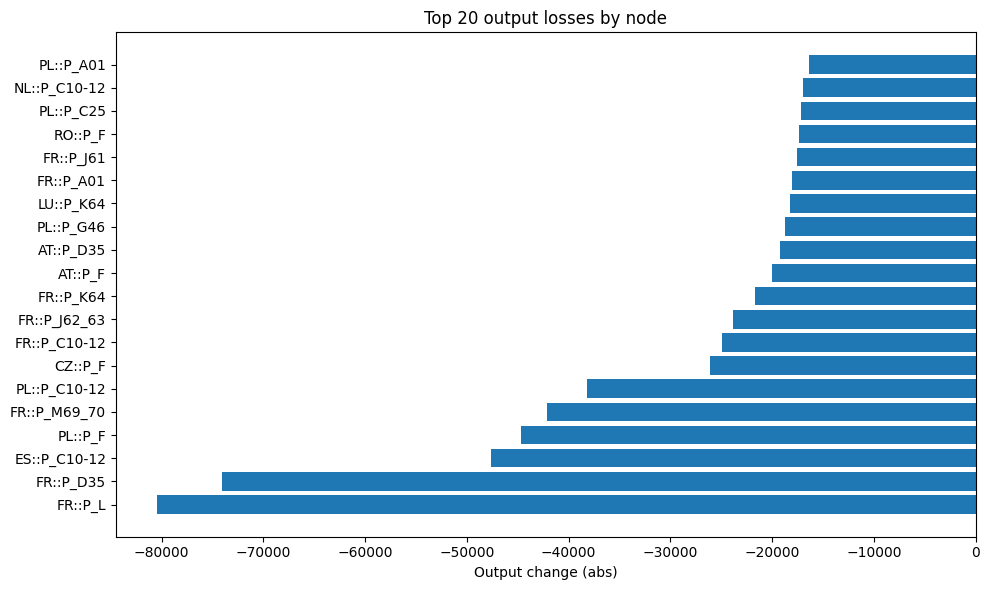

In [11]:
top = df_nodes.sort_values("X_change_abs").head(20)

try:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.barh(top["node"], top["X_change_abs"])
    plt.xlabel("Output change (abs)")
    plt.title("Top 20 output losses by node")
    plt.tight_layout()
    plt.show()

except ModuleNotFoundError:
    print("matplotlib not installed. Showing top 20 losses as a table instead.")
    display(top[["node","X_change_pct","X_baseline","X_final"]])


## 6) Demand consistency diagnostics


In [12]:
df_demand = pd.DataFrame({
    "node": node_labels,
    "FD_post": FD_post,
    "FD_implied": FD_implied,
    "delta": FD_implied - FD_post
})
df_demand["abs_delta"] = df_demand["delta"].abs()

print("Total FD_post:", float(df_demand["FD_post"].sum()))
print("Total FD_implied:", float(df_demand["FD_implied"].sum()))
df_demand.sort_values("abs_delta", ascending=False).head(10)


Total FD_post: 13755825.2597109
Total FD_implied: 13755825.328284368


,node,FD_post,FD_implied,delta,abs_delta
1494,RO::P_N78,-0.040412,0.000000,4.041222e-02,4.041222e-02
734,FR::P_K66,-0.022915,0.000000,2.291482e-02,2.291482e-02
1251,MT::P_S94,-0.005246,0.000000,5.246423e-03,5.246423e-03
972,IT::P_G46,105918.707348,105918.707348,1.455192e-11,1.455192e-11
318,DE::P_C10-12,103936.412543,103936.412543,1.455192e-11,1.455192e-11
973,IT::P_G47,122476.229185,122476.229185,1.455192e-11,1.455192e-11
347,DE::P_H52,93870.550799,93870.550799,1.455192e-11,1.455192e-11
329,DE::P_C25,34825.235002,34825.235002,1.455192e-11,1.455192e-11
326,DE::P_C22,23260.314372,23260.314372,7.275958e-12,7.275958e-12
352,DE::P_J61,9338.174216,9338.174216,7.275958e-12,7.275958e-12


In [13]:


X_baseline = X_baseline  # stored before model.run()
X_final = results["X_supply_final"]

df_nodes = pd.DataFrame({
    "node": node_labels,
    "country": [lbl.split("::")[0] for lbl in node_labels],
    "sector": [lbl.split("::")[1] for lbl in node_labels],
    "X_baseline": X_baseline,
    "X_final": X_final,
})

df_nodes["loss_abs"] = df_nodes["X_baseline"] - df_nodes["X_final"]
df_nodes["loss_pct"] = np.where(
    df_nodes["X_baseline"] > 0,
    100.0 * df_nodes["loss_abs"] / df_nodes["X_baseline"],
    0.0,
)

df_nodes.head()


,node,country,sector,X_baseline,X_final,loss_abs,loss_pct
0,AT::P_A01,AT,P_A01,10170.862001,9085.178543,1085.683457,10.674449
1,AT::P_A02,AT,P_A02,2903.627000,2049.720302,853.906698,29.408278
2,AT::P_A03,AT,P_A03,111.881000,88.314425,23.566575,21.063965
3,AT::P_B,AT,P_B,3452.811000,2756.738549,696.072451,20.159587
4,AT::P_C10-12,AT,P_C10-12,28074.827001,25452.008536,2622.818465,9.342243


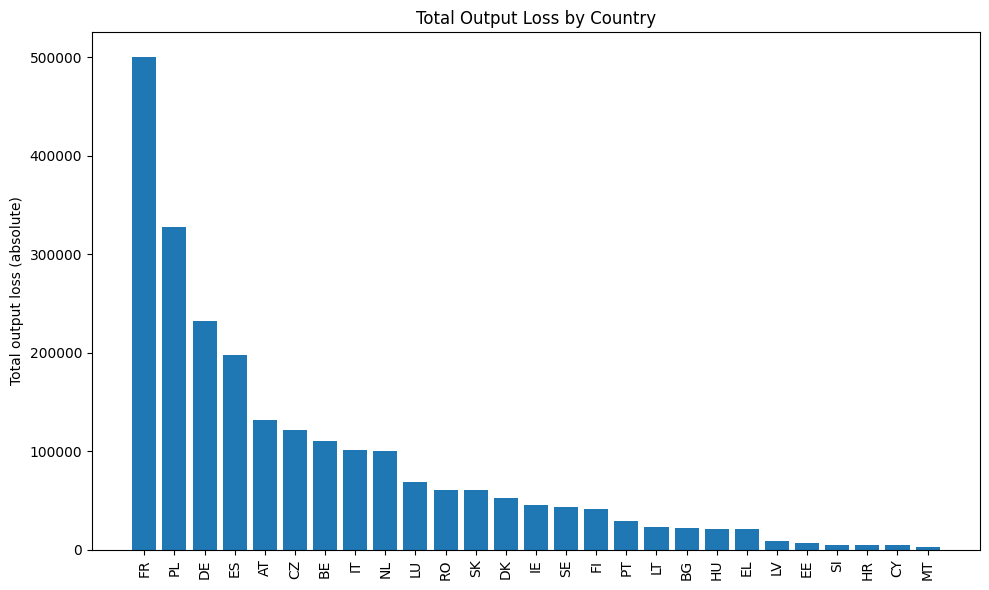

In [14]:
df_country = (
    df_nodes
    .groupby("country", as_index=False)
    .agg(
        X_baseline=("X_baseline", "sum"),
        X_final=("X_final", "sum"),
        loss_abs=("loss_abs", "sum"),
    )
)

df_country["loss_pct"] = 100.0 * df_country["loss_abs"] / df_country["X_baseline"]
df_country = df_country.sort_values("loss_abs", ascending=False)

df_country.head()


plt.figure(figsize=(10, 6))
plt.bar(df_country["country"], df_country["loss_abs"])
plt.xticks(rotation=90)
plt.ylabel("Total output loss (absolute)")
plt.title("Total Output Loss by Country")
plt.tight_layout()
plt.show()


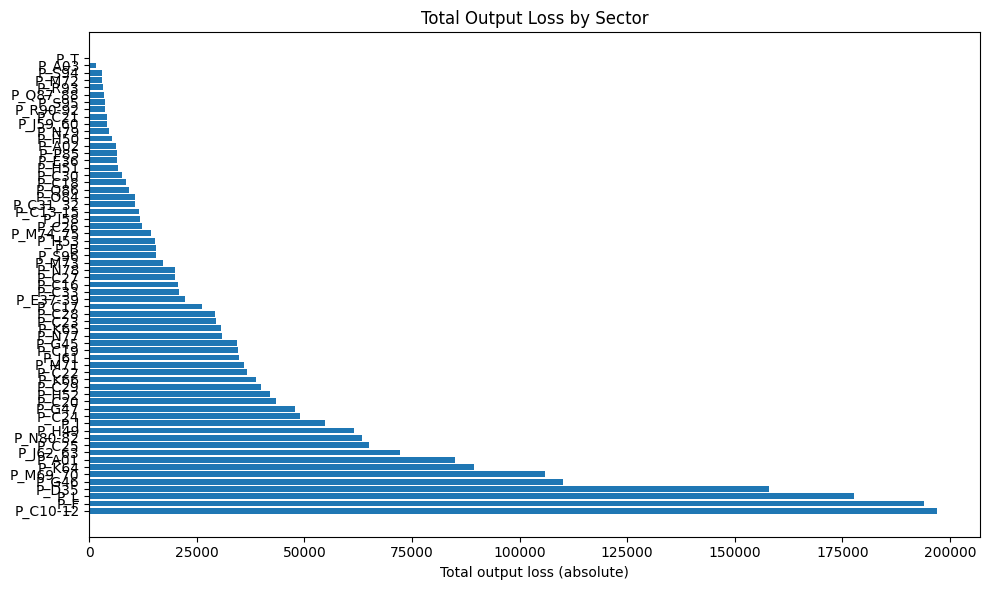

In [15]:
df_sector = (
    df_nodes
    .groupby("sector", as_index=False)
    .agg(
        X_baseline=("X_baseline", "sum"),
        X_final=("X_final", "sum"),
        loss_abs=("loss_abs", "sum"),
    )
)

df_sector["loss_pct"] = 100.0 * df_sector["loss_abs"] / df_sector["X_baseline"]
df_sector = df_sector.sort_values("loss_abs", ascending=False)

df_sector.head()

plt.figure(figsize=(10, 6))
plt.barh(df_sector["sector"], df_sector["loss_abs"])
plt.xlabel("Total output loss (absolute)")
plt.title("Total Output Loss by Sector")
plt.tight_layout()
plt.show()


In [16]:
import pycountry

def iso2_to_iso3(iso2):
    try:
        return pycountry.countries.get(alpha_2=iso2).alpha_3
    except Exception:
        return None


In [17]:

# Node-level table (baseline must be stored before run)
X_final = results["X_supply_final"]

df_nodes = pd.DataFrame({
    "node": node_labels,
    "country": [lbl.split("::")[0] for lbl in node_labels],
    "sector":  [lbl.split("::")[1] for lbl in node_labels],
    "X_baseline": X_baseline,
    "X_final": X_final,
})

df_nodes["loss_abs"] = df_nodes["X_baseline"] - df_nodes["X_final"]
df_nodes["loss_pct"] = np.where(
    df_nodes["X_baseline"] > 0,
    100.0 * df_nodes["loss_abs"] / df_nodes["X_baseline"],
    0.0,
)

df_country = (
    df_nodes
    .groupby("country", as_index=False)
    .agg(
        X_baseline=("X_baseline", "sum"),
        X_final=("X_final", "sum"),
        loss_abs=("loss_abs", "sum"),
    )
)

df_country["loss_pct"] = np.where(
    df_country["X_baseline"] > 0,
    100.0 * df_country["loss_abs"] / df_country["X_baseline"],
    0.0,
)

df_country = df_country.sort_values("loss_abs", ascending=False)
df_country.head()


,country,X_baseline,X_final,loss_abs,loss_pct
11,FR,4.681131e+06,4.180776e+06,500354.874399,10.688760
21,PL,1.310212e+06,9.826117e+05,327600.126208,25.003599
5,DE,6.905942e+06,6.673726e+06,232216.859393,3.362566
9,ES,2.442810e+06,2.245055e+06,197754.637575,8.095376
0,AT,8.110387e+05,6.787732e+05,132265.517600,16.308164


In [18]:
df_country = (
    df_nodes
    .groupby("country", as_index=False)
    .agg(
        X_baseline=("X_baseline", "sum"),
        X_final=("X_final", "sum"),
        loss_abs=("loss_abs", "sum"),
    )
)

df_country["loss_pct"] = (
    100.0 * df_country["loss_abs"] / df_country["X_baseline"]
)

# Convert ISO-2 → ISO-3
df_country["iso3"] = df_country["country"].apply(iso2_to_iso3)

# Quick sanity check
df_country[["country", "iso3"]].head()


,country,iso3
0,AT,AUT
1,BE,BEL
2,BG,BGR
3,CY,CYP
4,CZ,CZE


In [19]:
import plotly.express as px

fig = px.choropleth(
    df_country,
    locations="iso3",
    locationmode="ISO-3",
    color="loss_abs",
    hover_name="country",
    hover_data={
        "loss_abs": True,
        "loss_pct": True,
        "iso3": False,
        "country": False,
    },
    color_continuous_scale="Reds",
    title="Total Output Loss by Country (absolute)",
)

fig.update_layout(
    geo=dict(showframe=False, showcoastlines=True),
    margin=dict(l=0, r=0, t=40, b=0),
)

fig.show()
